# NODE 2 Project 2

# Optimal Control of Car in Obstacle Avoidance Manoeuvre

Marvin Hertweck, Alassane Diagne

In [1]:
%load_ext autoreload
import casadi as ca
import numpy as np
from car_model import CarModel
import Milestone1 as m1
from scipy.ndimage import zoom
import os

## 1. Shooting with 30 nodes

### Step 1 - Create CarModel instance and get dynmaics

In [2]:
car = CarModel()
tf, states, controls, dynamics = car.get_system()
# states: x, y, v, beta, psi, wz, delta
# controls: steering angle velocity, breaking force, acceleration, gear

### Step 2 - Set initial conditions and initial guesses for controls 

In [3]:
# number of shoots (number of shooting notes - 1)
N = 30
t_grid = np.linspace(0, 1, N + 1)

In [4]:
x0 = np.array(
    [
        -30,  # initial x
        1,  # initial y
        10.0,  # initial speed
        0.0,  # beta
        0.0,  # initial psi
        0.0,  # initial wz
        0.0,  # initial delta
    ]
)
u0 = np.zeros((30, 4))
# we got this by playing around witht the controls
u0[:, 0] = np.array(
    [
        0.00,
        0.00,
        -0.01,
        0.02,
        0.017,
        0.01,
        0.00,
        -0.015,
        -0.03,
        -0.035,
        -0.03,
        0.02,
        -0.0,
        0.015,
        0.05,
        0.0,
        0.025,
        0.01,
        -0.015,
        -0.03,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
    ]
)
u0[:, 2] = 0.3
u0[:, 3] = 1  # first gear

### Step 3 - Define objective function

$\min\limits_{x,u, tf} t_f + \int_0^1 w_\delta $

s.t. $\dot x = t_f*f(t,x,u)\quad, t\in[0,1]\quad$,    $x,u$ satisfy constraints

In [5]:
quad = tf * ca.dot(controls[0], controls[0])
rhs = {"x": states, "p": ca.vertcat(controls, tf), "ode": dynamics, "quad": tf + quad}

### Step 4 - Setup Multiple Shooting

In [6]:
ms = m1.ms_ocp(rhs, nx=7, N=N, T=1, tf=tf, nu=4)

### Step 5 - Set terminal and path constraints

In [7]:
terminal_cond = [
    ms["X"][-1][0] - 140,  # finish at x = 140
    ms["X"][-1][4],  # psi (yaw angle) at end is 0
]

B = 1.5
h1, h2, h3, h4 = 1.1 * B + 0.25, 3.5, 1.2 * B + 3.75, 1.3 * B + 0.25
lb_track_conditions = [x[1] - car.make_track(x[0], h1, h2, h3, h4)[0] for x in ms["X"]]
ub_track_conditions = [-x[1] + car.make_track(x[0], h1, h2, h3, h4)[1] for x in ms["X"]]

In [8]:
B = 1.5
h1, h2, h3, h4 = 1.1 * B + 0.25, 3.5, 1.2 * B + 3.75, 1.3 * B + 0.25
lb_track_conditions = [
    x[1] - car.make_track(x[0], h1, h2, h3, h4)[0] - B / 2 for x in ms["X"]
]
ub_track_conditions = [
    -x[1] + car.make_track(x[0], h1, h2, h3, h4)[1] - B / 2 for x in ms["X"]
]

In [9]:
gear = 1  # for simplicity, the gear is fixed in this problem

### Step 6 - Add constraints to Shooting variables

In [10]:
setup = m1.add_constraints(
    ms_data=ms,
    x_bounds=car.get_state_bounds(),
    u_bounds=car.get_controls_bounds(gear),
    extra_eq=terminal_cond,
    extra_ineq=lb_track_conditions + ub_track_conditions,
    x0_val=x0,  # fixed initial state
)

### Step 7 - get all initial states by integrating using initial guess for controls and final time

In [11]:
tf0 = 15  # inital guess for final time
xs0 = [x0]
F = ca.integrator("F", "cvodes", rhs, 0, 1 / N)
for k in range(N):
    res = F(x0=xs0[k], p=np.concatenate((u0[k], [tf0])))
    xs0.append(res["xf"].full().squeeze())
xs0 = np.array(xs0)
w0 = np.concatenate((xs0.flatten(), u0.flatten(), [tf0]))

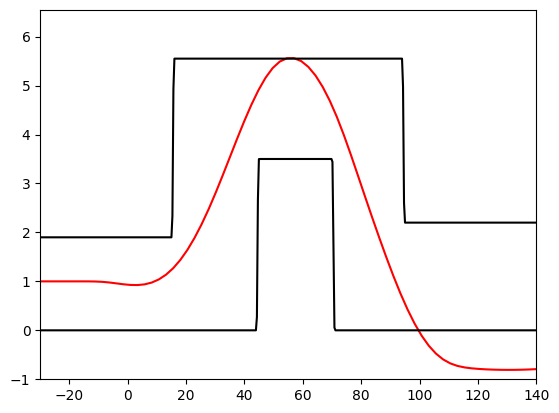

In [12]:
# plot initial trajectory
car.plot_trajectory(u0, x0, t_grid, tf0, (h1, h2, h3, h4), (-30, 140), smoothing=3)

### Step 8 - solve using ipopt

In [13]:
solver = ca.nlpsol("solver", "ipopt", setup["prob"])

In [14]:
# set initial y free
lbx = setup["lbx"].copy()
ubx = setup["ubx"].copy()
lbx[1] = -np.inf
ubx[1] = np.inf

In [15]:
sol = solver(x0=w0, lbx=lbx, ubx=ubx, lbg=setup["lbg"], ubg=setup["ubg"])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1863
Number of nonzeros in inequality constraint Jacobian.:      122
Number of nonzeros in Lagrangian Hessian.............:     1316

Total number of variables............................:      302
                     variables with only lower bounds:       30
                variables with lower and upper bounds:       91
                     variables with only upper bounds:        0
Total number of equality constraints.................:      212
Total number of inequality c

In [16]:
w_opt = sol["x"].full().flatten()

### Step 9 - extract solution

In [17]:
nx = ms["X"][0].numel()
nu = ms["U"][0].numel()
N = len(ms["U"])
states_30 = w_opt[: (N + 1) * nx].reshape(N + 1, nx)
controls_30 = w_opt[(N + 1) * nx : -1].reshape(N, nu)
final_time_30 = w_opt[-1]

### Step 10 - Visualize

In [18]:
print("Final x:", states_30[-1, 0])
print("Final y:", states_30[-1, 1])
print("Final yaw angle", states_30[-1, 4])
print("Final time:", final_time_30)

Final x: 140.0
Final y: 1.048701060452547
Final yaw angle 0.0
Final time: 11.208465365016462


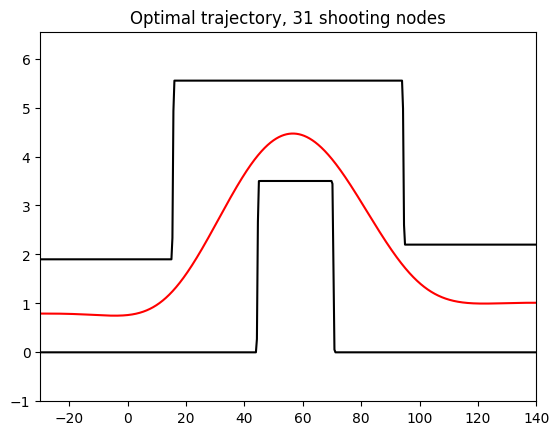

In [19]:
car.plot_trajectory(
    controls_30,
    states_30[0],
    t_grid,
    final_time_30,
    smoothing=100,  # we use a smoothing parameter so that we do not just interpolate linearlly
    track_params=(h1, h2, h3, h4),
    track_limits=(-30, 140),
    title="Optimal trajectory, 31 shooting nodes",
)

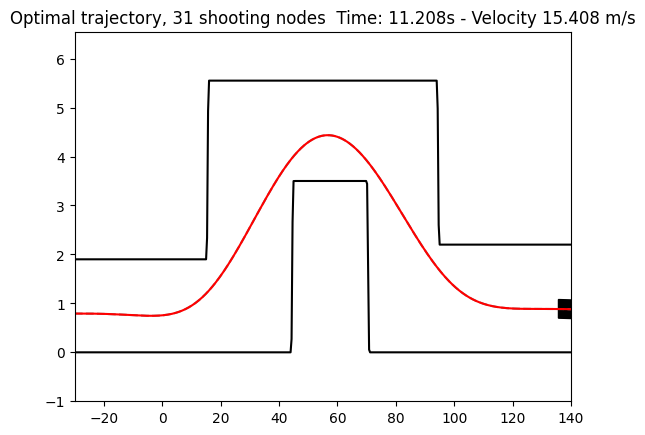

In [20]:
os.makedirs("animations", exist_ok=True)
car.animate(
    controls_30,
    states_30[0],
    t_grid,
    final_time_30,
    smoothing=20,  # we use a smoothing parameter so that we do not just interpolate linearlly
    track_params=(h1, h2, h3, h4),
    track_limits=(-30, 140),
    title="Optimal trajectory, 31 shooting nodes",
    filename="animations/30nodes.mp4",
)

## 2. Shooting with 51 and 81 nodes

In [21]:
def stretch_array(arr, new_shape):
    """
    Stretches array using linear interpolation
    """
    zoom_factors = [n / o for n, o in zip(new_shape, arr.shape)]
    return zoom(arr, zoom_factors)

### 51 nodes

In [22]:
N = 50
t_grid = np.linspace(0, 1, N + 1)

# get new initial controls by interpolation
u0 = stretch_array(u0, (N, 4))

# setup Multiple Shooting
ms = m1.ms_ocp(rhs, nx=7, N=N, T=1, tf=tf, nu=4)

# set terminal and track conditions (we need to redefine them because ms if different now)
terminal_cond = [
    ms["X"][-1][0] - 140,  # finish at x = 140
    ms["X"][-1][4],  # psi (yaw angle) at end is 0
]

lb_track_conditions = [
    x[1] - car.make_track(x[0], h1, h2, h3, h4)[0] - B / 2 for x in ms["X"]
]
ub_track_conditions = [
    -x[1] + car.make_track(x[0], h1, h2, h3, h4)[1] - B / 2 for x in ms["X"]
]

# create initial guess
tf0 = 15  # inital guess for final time
xs0 = [x0]
F = ca.integrator("F", "cvodes", rhs, 0, 1 / N)
for k in range(N):
    res = F(x0=xs0[k], p=np.concatenate((u0[k], [tf0])))
    xs0.append(res["xf"].full().squeeze())
xs0 = np.array(xs0)
w0 = np.concatenate((xs0.flatten(), u0.flatten(), [tf0]))

# add constraints
setup = m1.add_constraints(
    ms_data=ms,
    x_bounds=car.get_state_bounds(),
    u_bounds=car.get_controls_bounds(gear),
    extra_eq=terminal_cond,
    extra_ineq=lb_track_conditions + ub_track_conditions,
    x0_val=x0,  # fixed initial state
)

# set initial y free
lbx = setup["lbx"].copy()
ubx = setup["ubx"].copy()
lbx[1] = -np.inf
ubx[1] = np.inf

In [23]:
# solve

solver = ca.nlpsol("solver", "ipopt", setup["prob"])
sol_50 = solver(x0=w0, lbx=lbx, ubx=ubx, lbg=setup["lbg"], ubg=setup["ubg"])

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3123
Number of nonzeros in inequality constraint Jacobian.:      202
Number of nonzeros in Lagrangian Hessian.............:     2216

Total number of variables............................:      502
                     variables with only lower bounds:       50
                variables with lower and upper bounds:      151
                     variables with only upper bounds:        0
Total number of equality constraints.................:      352
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:      102
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5004340e+01 4.66e+01 9.66e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [24]:
w_opt_50 = sol_50["x"].full().flatten()
nx = ms["X"][0].numel()
nu = ms["U"][0].numel()
states_50 = w_opt_50[: (N + 1) * nx].reshape(N + 1, nx)
controls_50 = w_opt_50[(N + 1) * nx : -1].reshape(N, nu)
final_time_50 = w_opt_50[-1]

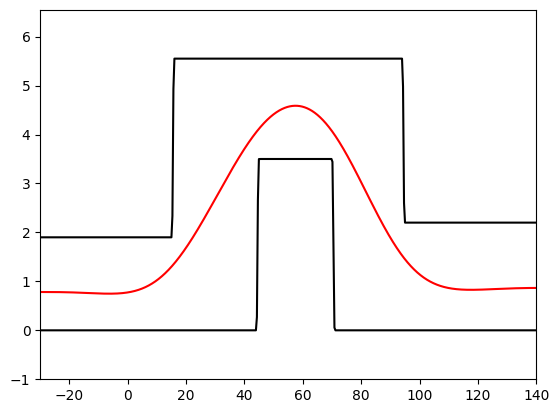

In [25]:
car.plot_trajectory(
    controls_50, states_50[0], t_grid, final_time_50, (h1, h2, h3, h4), (-30, 140), 200
)

### 81 nodes

In [26]:
N = 80
t_grid = np.linspace(0, 1, N + 1)

# get new initial controls by interpolation
u0 = stretch_array(u0, (N, 4))

# setup Multiple Shooting
ms = m1.ms_ocp(rhs, nx=7, N=N, T=1, tf=tf, nu=4)

# set terminal and track conditions (we need to redefine them because ms if different now)
terminal_cond = [
    ms["X"][-1][0] - 140,  # finish at x = 140
    ms["X"][-1][4],  # psi (yaw angle) at end is 0
]

lb_track_conditions = [
    x[1] - car.make_track(x[0], h1, h2, h3, h4)[0] - B / 2 for x in ms["X"]
]
ub_track_conditions = [
    -x[1] + car.make_track(x[0], h1, h2, h3, h4)[1] - B / 2 for x in ms["X"]
]

# create initial guess
tf0 = 15  # inital guess for final time
xs0 = [x0]
F = ca.integrator("F", "cvodes", rhs, 0, 1 / N)
for k in range(N):
    res = F(x0=xs0[k], p=np.concatenate((u0[k], [tf0])))
    xs0.append(res["xf"].full().squeeze())
xs0 = np.array(xs0)
w0 = np.concatenate((xs0.flatten(), u0.flatten(), [tf0]))

# add constraints
setup = m1.add_constraints(
    ms_data=ms,
    x_bounds=car.get_state_bounds(),
    u_bounds=car.get_controls_bounds(gear),
    extra_eq=terminal_cond,
    extra_ineq=lb_track_conditions + ub_track_conditions,
    x0_val=x0,  # fixed initial state
)

# set initial y free
lbx = setup["lbx"].copy()
ubx = setup["ubx"].copy()
lbx[1] = -np.inf
ubx[1] = np.inf

In [27]:
solver = ca.nlpsol("solver", "ipopt", setup["prob"])
sol_80 = solver(
    x0=w0, lbx=lbx, ubx=ubx, lbg=setup["lbg"], ubg=setup["ubg"]
)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5013
Number of nonzeros in inequality constraint Jacobian.:      322
Number of nonzeros in Lagrangian Hessian.............:     3566

Total number of variables............................:      802
                     variables with only lower bounds:       80
                variables with lower and upper bounds:      241
                     variables with only upper bounds:        0
Total number of equality constraints.................:      562
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:      162
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5004353e+01 4.65e+01 9.68e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

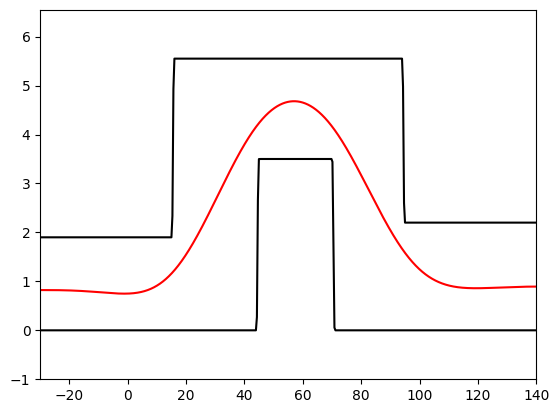

In [28]:
w_opt_80 = sol_80["x"].full().flatten()
nx = ms["X"][0].numel()
nu = ms["U"][0].numel()
states_80 = w_opt_80[: (N + 1) * nx].reshape(N + 1, nx)
controls_80 = w_opt_80[(N + 1) * nx : -1].reshape(N, nu)
final_time_80 = w_opt_80[-1]
car.plot_trajectory(
    controls_80, states_80[0], t_grid, final_time_80, (h1, h2, h3, h4), (-30, 140), 200
)

As we can see, 31 nodes give us already pretty good results, way faster (53s vs 388s vs 512s) in ipopt. Hence, we will limit ourselves to 30 shooting nodes in the following tests.

## 3. What happens, when we do not add $w_\delta$ in the minimization?

In [29]:
N = 30
t_grid = np.linspace(0, 1, N + 1)

# get new initial controls by interpolation
u0 = stretch_array(u0, (N, 4))

# define new righthand side
tf, states, controls, dynamics = car.get_system()
new_rhs = {"x": states, "p": ca.vertcat(controls, tf), "ode": dynamics, "quad": tf}

# setup Multiple Shooting
new_ms = m1.ms_ocp(new_rhs, nx=7, N=N, T=1, tf=tf, nu=4)

# set terminal and track conditions (we need to redefine them because ms if different now)
terminal_cond = [
    new_ms["X"][-1][0] - 140,  # finish at x = 140
    new_ms["X"][-1][4],  # psi (yaw angle) at end is 0
]

lb_track_conditions = [
    x[1] - car.make_track(x[0], h1, h2, h3, h4)[0] - B / 2 for x in new_ms["X"]
]
ub_track_conditions = [
    -x[1] + car.make_track(x[0], h1, h2, h3, h4)[1] - B / 2 for x in new_ms["X"]
]

# create initial guess
tf0 = 15  # inital guess for final time
xs0 = [x0]
F = ca.integrator("F", "cvodes", rhs, 0, 1 / N)
for k in range(N):
    res = F(x0=xs0[k], p=np.concatenate((u0[k], [tf0])))
    xs0.append(res["xf"].full().squeeze())
xs0 = np.array(xs0)
w0 = np.concatenate((xs0.flatten(), u0.flatten(), [tf0]))

# add constraints
setup = m1.add_constraints(
    ms_data=new_ms,
    x_bounds=car.get_state_bounds(),
    u_bounds=car.get_controls_bounds(gear),
    extra_eq=terminal_cond,
    extra_ineq=lb_track_conditions + ub_track_conditions,
    x0_val=x0,  # fixed initial state
)

lbx = setup["lbx"].copy()
ubx = setup["ubx"].copy()
lbx[1] = -np.inf
ubx[1] = np.inf

# solve
solver = ca.nlpsol("solver", "ipopt", setup["prob"])
sol_newobj = solver(
    x0=w0, lbx=lbx, ubx=ubx, lbg=setup["lbg"], ubg=setup["ubg"]
)

w_opt_newobj = sol_newobj["x"].full().flatten()
nx = ms["X"][0].numel()
nu = ms["U"][0].numel()
states_newobj = w_opt_newobj[: (N + 1) * nx].reshape(N + 1, nx)
controls_newobj = w_opt_newobj[(N + 1) * nx : -1].reshape(N, nu)
final_time_newobj = w_opt_newobj[-1]

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1863
Number of nonzeros in inequality constraint Jacobian.:      122
Number of nonzeros in Lagrangian Hessian.............:     1316

Total number of variables............................:      302
                     variables with only lower bounds:       30
                variables with lower and upper bounds:       91
                     variables with only upper bounds:        0
Total number of equality constraints.................:      212
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5000000e+01 4.66e+01 9.63e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

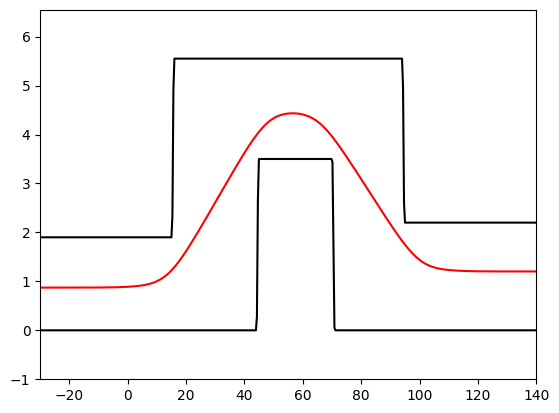

In [30]:
car.plot_trajectory(
    controls_newobj,
    states_newobj[0],
    t_grid,
    final_time_newobj,
    (h1, h2, h3, h4),
    (-30, 140),
    smoothing=100,
)

The trajectory looks the same, what about the steering angle velocity?

In [31]:
print(f"||w_delta|| with original objective {np.linalg.norm(controls_30[:,0])}")
print(f"||w_delta|| with changed objective {np.linalg.norm(controls_newobj[:,0])}")

||w_delta|| with original objective 0.05593487336745746
||w_delta|| with changed objective 0.17196079592502833


This shows, that the original objective leads to controls that let the driver drive more comfortably. And the time we might have saved by ignoring the steering angle velocity is negligible

In [32]:
print(f"Time saved: {final_time_30 - final_time_newobj}s")

Time saved: 0.0003990568922986881s


## 4. Can we drive in second and third gear?

In [39]:
car = CarModel()
gear = 2
N = 30
t_grid = np.linspace(0, 1, N + 1)

# get new initial controls by interpolation
u0 = stretch_array(u0, (N, 4))

# setup Multiple Shooting
ms = m1.ms_ocp(rhs, nx=7, N=N, T=1, tf=tf, nu=4)

# set terminal and track conditions (we need to redefine them because ms if different now)
terminal_cond = [
    ms["X"][-1][0] - 140,  # finish at x = 140
    ms["X"][-1][4],  # psi (yaw angle) at end is 0
]

lb_track_conditions = [
    x[1] - car.make_track(x[0], h1, h2, h3, h4)[0] - B / 2 for x in ms["X"]
]
ub_track_conditions = [
    -x[1] + car.make_track(x[0], h1, h2, h3, h4)[1] - B / 2 for x in ms["X"]
]

# create initial guess
tf0 = 15  # inital guess for final time
xs0 = [x0]
F = ca.integrator("F", "cvodes", rhs, 0, 1 / N)
for k in range(N):
    res = F(x0=xs0[k], p=np.concatenate((u0[k], [tf0])))
    xs0.append(res["xf"].full().squeeze())
xs0 = np.array(xs0)
w0 = np.concatenate((xs0.flatten(), u0.flatten(), [tf0]))

# add constraints
setup = m1.add_constraints(
    ms_data=ms,
    x_bounds=car.get_state_bounds(),
    u_bounds=car.get_controls_bounds(gear),
    extra_eq=terminal_cond,
    extra_ineq=lb_track_conditions + ub_track_conditions,
    x0_val=x0,  # fixed initial state
)

lbx = setup["lbx"].copy()
ubx = setup["ubx"].copy()
lbx[1] = -np.inf
ubx[1] = np.inf

solver = ca.nlpsol("solver", "ipopt", setup["prob"])
sol_2ndgear = solver(
    x0=w0, lbx=lbx, ubx=ubx, lbg=setup["lbg"], ubg=setup["ubg"]
)

w_opt_2ndgear = sol_2ndgear["x"].full().flatten()
nx = ms["X"][0].numel()
nu = ms["U"][0].numel()
states_2ndgear = w_opt_2ndgear[: (N + 1) * nx].reshape(N + 1, nx)
controls_2ndgear = w_opt_2ndgear[(N + 1) * nx : -1].reshape(N, nu)
final_time_2ndgear = w_opt_2ndgear[-1]

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1863
Number of nonzeros in inequality constraint Jacobian.:      122
Number of nonzeros in Lagrangian Hessian.............:     1316

Total number of variables............................:      302
                     variables with only lower bounds:       30
                variables with lower and upper bounds:       91
                     variables with only upper bounds:        0
Total number of equality constraints.................:      212
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5004478e+01 4.66e+01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [40]:
gear = 3

# add constraints
setup = m1.add_constraints(
    ms_data=ms,
    x_bounds=car.get_state_bounds(),
    u_bounds=car.get_controls_bounds(gear),
    extra_eq=terminal_cond,
    extra_ineq=lb_track_conditions + ub_track_conditions,
    x0_val=x0,  # fixed initial state
)

lbx = setup["lbx"].copy()
ubx = setup["ubx"].copy()
lbx[1] = -np.inf
ubx[1] = np.inf


solver = ca.nlpsol("solver", "ipopt", setup["prob"])
sol_3rdgear = solver(
    x0=w0, lbx=lbx, ubx=ubx, lbg=setup["lbg"], ubg=setup["ubg"]
)

w_opt_3rdgear = sol_3rdgear["x"].full().flatten()
nx = ms["X"][0].numel()
nu = ms["U"][0].numel()
states_3rdgear = w_opt_3rdgear[: (N + 1) * nx].reshape(N + 1, nx)
controls_3rdgear = w_opt_3rdgear[(N + 1) * nx : -1].reshape(N, nu)
final_time_3rdgear = w_opt_3rdgear[-1]

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1863
Number of nonzeros in inequality constraint Jacobian.:      122
Number of nonzeros in Lagrangian Hessian.............:     1316

Total number of variables............................:      302
                     variables with only lower bounds:       30
                variables with lower and upper bounds:       91
                     variables with only upper bounds:        0
Total number of equality constraints.................:      212
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5004478e+01 4.66e+01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

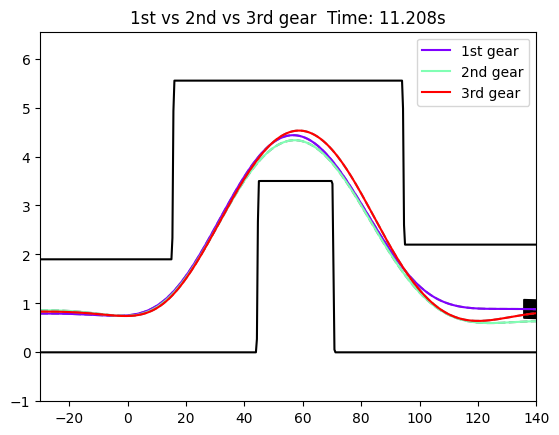

In [41]:
car.animate_race(
    [controls_30, controls_2ndgear, controls_3rdgear],
    [states_30[0], states_2ndgear[0], states_3rdgear[0]],
    [np.linspace(0, 1, 31), np.linspace(0, 1, 31), np.linspace(0, 1, 31)],
    [final_time_30, final_time_2ndgear, final_time_3rdgear],
    labels=["1st gear", "2nd gear", "3rd gear"],
    track_params=(h1, h2, h3, h4),
    track_limits=(-30, 140),
    smoothing=20,
    title="1st vs 2nd vs 3rd gear",
    filename="animations/gears_comparison.mp4",
)

In [42]:
print(
    f"""Final time in \n1. gear: {round(final_time_50,3)}s,
2. gear: {round(final_time_2ndgear,3)}s,
3. gear: {round(final_time_3rdgear,3)}s """
)

Final time in 
1. gear: 11.211s,
2. gear: 7.254s,
3. gear: 7.95s 


Interestingly, the numbers and the animation show, that we are faster in 2nd gear than in 3rd gear. This is probably due to the fact, that we have a very low RPM at the initial speed (10m/s) in the third gear and thus we need longer to accelerate.

## 5. Test our SQP solver

In [37]:
from sqp_method import ms_sqp_method

First check: see if it work with optimal solution (it should perform only a few iterations, if at all)

In [38]:
gear = 1  # back to first gear

w0 = np.concatenate((states_30.flatten(), controls_30.flatten(), [final_time_30]))

# add constraints
setup = m1.add_constraints(
    ms_data=ms,
    x_bounds=car.get_state_bounds(),
    u_bounds=car.get_controls_bounds(gear),
    extra_eq=terminal_cond,
    extra_ineq=lb_track_conditions + ub_track_conditions,
    x0_val=x0,  # fixed initial state
)

ms_sqp_method(setup, ms["w"], w0)

SQP method: iteration 0

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

SQP method: iter

{'x': array([-3.00000000e+01,  1.00000000e+00,  1.00000000e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.56708295e+01,
         7.91050915e-01,  1.29284543e+01,  7.42867894e-05, -3.41214121e-04,
        -2.29278280e-03, -6.80524257e-04, -2.05213101e+01,  7.86230912e-01,
         1.44345167e+01, -5.32177436e-05, -1.58841882e-03, -4.10344924e-03,
        -8.77188884e-04, -1.49948016e+01,  7.74086571e-01,  1.50520201e+01,
        -1.77619856e-04, -2.96664503e-03, -2.73574188e-03, -3.87658472e-04,
        -9.32118220e+00,  7.57337549e-01,  1.52812973e+01, -1.42426367e-04,
        -2.87910995e-03,  4.09607640e-03,  1.23978541e-03, -3.59395771e+00,
         7.50004444e-01,  1.53631624e+01,  1.71246818e-04,  1.20846142e-03,
         1.90809765e-02,  4.53900139e-03,  2.15208917e+00,  7.82283609e-01,
         1.53915557e+01,  8.99033846e-04,  1.24720926e-02,  4.23890701e-02,
         9.35828476e-03,  7.90333054e+00,  8.99937574e-01,  1.54004340e+01,
       

## 6. Another track: Fast, sharp corner